In [ ]:
#|hide
#|eval: false
! [ -e /content ] && pip install -Uqq fastrl['dev'] pyvirtualdisplay && \
                     apt-get install -y xvfb python-opengl > /dev/null 2>&1 
# NOTE: IF YOU SEE VERSION ERRORS, IT IS SAFE TO IGNORE THEM. COLAB IS BEHIND IN SOME OF THE PACKAGE VERSIONS

In [ ]:
#|hide
#|eval: false
from fastcore.imports import in_colab
# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev.showdoc import *
    from nbdev.imports import *
    if not os.environ.get("IN_TEST", None):
        assert IN_NOTEBOOK
        assert not IN_COLAB
        assert IN_IPYTHON
else:
    # Virutual display is needed for colab
    from pyvirtualdisplay import Display
    display = Display(visible=0, size=(400, 300))
    display.start()

In [ ]:
#|default_exp agents.ddpg

In [ ]:
#|export
# Python native modules
import os
from typing import *
from typing_extensions import Literal
from copy import deepcopy
# Third party libs
from fastcore.all import *
import torchdata.datapipes as dp
from torch import nn
import torch
from  torchdata.dataloader2.graph import DataPipe,traverse
import numpy as np
import pandas as pd
from torch.optim import AdamW,Adam
import numpy as np
# Local modules
from fastrl.core import *
from fastrl.torch_core import *
from fastrl.pipes.core import *
from fastrl.data.block import *
from fastrl.data.dataloader2 import *
from fastrl.agents.core import *
from fastrl.memory.experience_replay import ExperienceReplay
from fastrl.learner.core import *
from fastrl.loggers.core import *

# DDPG 
> Deep Deterministic Policy Gradiant for continuous action domains

[(Lillicrap et al., 2016) [DDPG] Continuous Control with Deep Reinforcement Learning](https://arxiv.org/abs/1509.02971) based on the 
DPG algorithm in [(Silver et al., 2014) [DPG] Deterministic Policy Gradient Algorithms](http://proceedings.mlr.press/v32/silver14.pdf).

DDPG uses an actor-critic architecture and has a similar training / learning paradym to DQNs.

Below is `(Lillicrap et al., 2016) Algorithm 1` that summarizes DDPG. 

<img src="../../images/(Lilicrap et al., 2016) DDPG Algorithm 1.png" width="947" height="694">

## Model

In [ ]:
#|export
def init_xavier_uniform_weights(m:Module,bias=0.01):
    "Initializes weights for linear layers using `torch.nn.init.xavier_uniform_`"
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(bias)

In [ ]:
#|export
def init_uniform_weights(m:Module,bound):
    "Initializes weights for linear layers using `torch.nn.init.uniform_`"
    if type(m) == nn.Linear:
        torch.nn.init.uniform_(m.weight,-bound,bound)

In [ ]:
#|export
def init_kaiming_normal_weights(m:Module,bias=0.01):
    "Initializes weights for linear layers using `torch.nn.init.kaiming_normal_`"
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(bias)

`Lilicrap et al., 2016` pg 11 notes: 
"The other layers were initialized from uniform distributions $[ \frac{-1}{\sqrt{f}},\frac{1}{\sqrt{f}}]$ where f is the fan-in of the layer."

`init_kaiming_normal_weights` is the most similar to this strategy. Other implimentations
of DDPGs have also used `init_xavier_uniform_weights`

> Note: There does not appear to be a major difference between performance of using either.

The same page notes:
"final layer weights and biases of both the actor and critic
were initialized from a uniform distribution $[−3 * 10^{−3}, 3 * 10^{−3}]$ and $[3 * 10^{−4}, 3 * 10^{−4}]$ for the
low dimensional and pixel cases respectively.", so the default value for `final_layer_init_fn` uses `init_uniform_weights`
with a bound of `1e-4` for low dim, and if pixels, needs to be changed to `1e-5`.

The same page notes:
"The low-dimensional networks had 2 hidden layers with 400 and 300 units respectively ... When learning from pixels we used 3 convolutional layers
(no pooling) with 32 filters at each layer. This was followed by two fully connected layers with
200 units"

We default to expect low-dimensions, and for images we will augment this.

In [ ]:
#|export
def ddpg_conv2d_block(
        # A tuple of state sizes generally representing an image of format: 
        # [channel,width,height]
        state_sz:Tuple[int,int,int],
        # Number of filters to use for each conv layer
        filters=32,
        # Activation function between each layer.
        activation_fn=nn.ReLU,
        # We assume the channels dim should be size 3 max. If it is more
        # we assume the width/height are in the location of channel and need to
        # be transposed.
        ignore_warning:bool=False
    ) -> Tuple[nn.Sequential,int]: # (Convolutional block,n_features_out)
    "Creates a 3 layer conv block from `state_sz` along with expected n_feature output shape."
    channels = state_sz[0]
    if channels>3 and not ignore_warning:
        warn(f'Channels is {channels}>3 in state_sz {state_sz}')
    layers = nn.Sequential(
        nn.BatchNorm2d(channels),
        nn.Conv2d(channels,channels,filters),
        activation_fn(),
        nn.Conv2d(channels,channels,filters),
        activation_fn(),
        nn.Conv2d(channels,channels,filters),   
        nn.Flatten()
    )
    m_layers = deepcopy(layers).to(device='meta')
    out_sz = m_layers(torch.ones((1,*state_sz),device='meta')).shape[-1]
    return layers.to(device='cpu'),out_sz


In [ ]:
ddpg_conv2d_block((3,100,100))

(Sequential(
   (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (1): Conv2d(3, 3, kernel_size=(32, 32), stride=(1, 1))
   (2): ReLU()
   (3): Conv2d(3, 3, kernel_size=(32, 32), stride=(1, 1))
   (4): ReLU()
   (5): Conv2d(3, 3, kernel_size=(32, 32), stride=(1, 1))
   (6): Flatten(start_dim=1, end_dim=-1)
 ),
 147)

In [ ]:
#|export
class Critic(Module):
    def __init__(
            self,
            state_sz:int,  # The input dim of the state / flattened conv output
            action_sz:int, # The input dim of the actions
            hidden1:int=400,    # Number of neurons connected between the 2 input/output layers
            hidden2:int=300,    # Number of neurons connected between the 2 input/output layers
            head_layer:Module=nn.Linear, # Output layer
            activation_fn:Module=nn.ReLU, # The activation function
            weight_init_fn:Callable=init_kaiming_normal_weights, # The weight initialization strategy
            # Final layer initialization strategy
            final_layer_init_fn:Callable=partial(init_uniform_weights,bound=1e-4),
            # For pixel inputs, we can plug in a `nn.Sequential` block from `ddpg_conv2d_block`.
            # This means that actions will be feed into the second linear layer instead of the 
            # first.
            conv_block:Optional[nn.Sequential]=None,
            # Whether to do batch norm. 
            batch_norm:bool=False
        ):
        self.action_sz = action_sz
        self.state_sz = state_sz
        self.conv_block = conv_block
        if conv_block is None:
            if batch_norm:
                ln_bn = nn.Sequential(
                    nn.BatchNorm1d(state_sz+action_sz),
                    nn.Linear(state_sz+action_sz,hidden1)
                )
            else:
                ln_bn = nn.Linear(state_sz+action_sz,hidden1)
            self.layers = nn.Sequential(
                ln_bn,
                activation_fn(),
                nn.Linear(hidden1,hidden2),
                activation_fn(),
                head_layer(hidden2,1),
            )
        else:
            self.conv_block = nn.Sequential(
                self.conv_block,
                nn.Linear(state_sz,hidden1),
                activation_fn(),
            )
            self.layers = nn.Sequential(
                nn.Linear(hidden1+action_sz,hidden2),
                activation_fn(),
                head_layer(hidden2,1),
            )
        self.layers.apply(weight_init_fn)
        if final_layer_init_fn is not None:
            final_layer_init_fn(self.layers[-1])

    def forward(
            self,
            s:torch.Tensor, # A single tensor of shape [Batch,`state_sz`]
            a:torch.Tensor # A single tensor of shape [Batch,`aciton_sz`]
            # A single tensor of shape [B,1] representing the cumulative value estimate of state+action combinations  
        ) -> torch.Tensor: 
            if self.conv_block:
                s = self.conv_block(s)
            return self.layers(torch.hstack((s,a)))

add_docs(
Critic,
"Takes a 2 tensors of size [B,`state_sz`], [B,`action_sz`] -> [B,1] outputs a 1d tensor representing the Q value",
forward="""Takes in a 2 tensors of a state tensor and action tensor and output
 the Q value estimates of that state,action combination"""
)

The `Critic` is used by `DDPG` to estimate the Q value of state-action pairs and is updated using the 
the Bellman-Equation similarly to DQN/Q-Learning and is represeted by $Q(s,a)$

Check that low dim input works...

In [ ]:
torch.manual_seed(0)
critic = Critic(4,2)

state = torch.randn(1,4)
action = torch.randn(1,2)

with torch.no_grad(),evaluating(critic):
    test_eq(
        str(critic(state,action)),
        str(tensor([[0.0083]]))
    )

Check that image input works...

In [ ]:
torch.manual_seed(0)

image_shape = (3,100,100)

conv_block,feature_out = ddpg_conv2d_block(image_shape)
critic = Critic(feature_out,2,conv_block=conv_block)

state = torch.randn(1,*image_shape)
action = torch.randn(1,2)

with torch.no_grad(),evaluating(critic):
    test_eq(
        str(critic(state,action)),
        str(tensor([[0.0102]]))
    )

In [ ]:
#|export
class Actor(Module):
    def __init__(
            self,
            state_sz:int,  # The input dim of the state
            action_sz:int, # The output dim of the actions
            hidden1:int=400,    # Number of neurons connected between the 2 input/output layers
            hidden2:int=300,    # Number of neurons connected between the 2 input/output layers
            head_layer:Module=nn.Linear, # Output layer
            activation_fn:Module=nn.ReLU, # The activiation function
            weight_init_fn:Callable=init_kaiming_normal_weights, # The weight initialization strategy
            # Final layer initialization strategy
            final_layer_init_fn:Callable=partial(init_uniform_weights,bound=1e-4),
            # For pixel inputs, we can plug in a `nn.Sequential` block from `ddpg_conv2d_block`.
            conv_block:Optional[nn.Sequential]=None,
            # Whether to do batch norm. 
            batch_norm:bool=False
        ):
        self.action_sz = action_sz
        self.state_sz = state_sz
        self.conv_block = conv_block
        if conv_block is None:
            if batch_norm:
                ln_bn = nn.Sequential(
                    nn.BatchNorm1d(state_sz),
                    nn.Linear(state_sz,hidden1)
                )
            else:
                ln_bn = nn.Linear(state_sz,hidden1)
            self.layers = nn.Sequential(
                ln_bn,
                activation_fn(),
                nn.Linear(hidden1,hidden2),
                activation_fn(),
                head_layer(hidden2,action_sz),
                nn.Tanh()
            )
        else:
            self.layers = nn.Sequential(
                self.conv_block,
                nn.Linear(state_sz,hidden1),
                activation_fn(),
                nn.Linear(hidden1,hidden2),
                activation_fn(),
                head_layer(hidden2,action_sz),
                nn.Tanh()
            )

        self.layers.apply(init_kaiming_normal_weights)
        if final_layer_init_fn is not None:
            final_layer_init_fn(self.layers[-2])

    def forward(self,x): return self.layers(x)

add_docs(
Actor,
"Takes a single tensor of size [B,`state_sz`] -> [B,`action_sz`] and outputs a tensor of actions.",
forward="""Takes in a state tensor and output
 the actions value mappings"""
)

The `Actor` is used by `DDPG` to predict actions based on state inputs and is represeted by $\mu(s|\theta^\mu)$

Check that low dim input works...

In [ ]:
torch.manual_seed(0)
actor = Actor(4,2)

state = torch.randn(1,4)

with torch.no_grad(),evaluating(actor):
    test_eq(
        str(actor(state)),
        str(tensor([[0.0101, 0.0083]]))
    )

Check that image input works...

In [ ]:
torch.manual_seed(0)

image_shape = (3,100,100)

conv_block,feature_out = ddpg_conv2d_block(image_shape)
actor = Actor(feature_out,2,conv_block=conv_block)

state = torch.randn(1,*image_shape)
action = torch.randn(1,2)

with torch.no_grad(),evaluating(actor):
    test_eq(
        str(actor(state)),
        str(tensor([[0.0100, 0.0100]]))
    )

In [ ]:
#|export
def pipe_to_device(pipe,device,debug=False):
    "Attempt to move an entire `pipe` and its pipeline to `device`"
    pipes = find_dps(traverse(pipe),dp.iter.IterDataPipe,include_subclasses=True)
    for pipe in pipes:
        if hasattr(pipe,'to'): 
            if debug: print(f'Moving {pipe} to {device}')
            pipe.to(device=device)

## Ornstein-Uhlenbeck Exploration

In [ ]:
#|export
class OrnsteinUhlenbeck(dp.iter.IterDataPipe):
	def __init__(
			self, 
			source_datapipe:DataPipe, # a datapipe whose next(source_datapipe) -> `Tensor` 
			action_sz:int, # The action dimension
			mu:float=0., # Used in preturbing continuous actions
			theta:float=0.15, # Used in preturbing continuous actions
			sigma:float=0.2, # Used in preturbing continuous actions
            min_epsilon:float=0.2, # The minimum epsilon to drop to
            # The max/starting epsilon if `epsilon` is None and used for calculating epislon decrease speed.
            max_epsilon:float=1, 
            # Determines how fast the episilon should drop to `min_epsilon`. This should be the number
            # of steps that the agent was run through.
            max_steps:int=100,
            # The starting epsilon which determines how much exploration to do.
			# epislon close to 1 does maximal exploration, while close to 0
			# does very little.
            epsilon:float=None,
            # Based on the `base_agent.model.training`, by default no decrement or step tracking will
            # occur during validation steps.
            decrement_on_val:bool=False,
            # Based on the `base_agent.model.training`, by default random actions will not be attempted
            explore_on_val:bool=False,
            # Also return the original action prior to exploratory noise
            ret_original:bool=False,
		):
		self.source_datapipe = source_datapipe
		self.min_epsilon = min_epsilon
		self.max_epsilon = max_epsilon
		self.max_steps = max_steps
		self.epsilon = epsilon
		self.decrement_on_val = decrement_on_val
		self.explore_on_val = explore_on_val
		self.ret_original = ret_original
		self.agent_base = None
		self.step = 0
		self.sigma = sigma
		self.theta = theta
		self.mu = mu
		self.device = None
		self.normal_dist = torch.distributions.Normal(0,1)
		self.x = torch.full((action_sz,),1).float()
		if not (self.decrement_on_val and self.explore_on_val):
			self.agent_base = find_dp(traverse(self.source_datapipe),AgentBase)

	def to(self,*args,**kwargs):
		self.device = kwargs.get('device',self.device)
		self.x = self.x.to(*args,**kwargs)
		self.normal_dist = torch.distributions.Normal(
			tensor(0).float().to(*args,**kwargs),
			tensor(1).float().to(*args,**kwargs)
		)

	def __iter__(self):
		for action in self.source_datapipe:
			# TODO: Support tuples of actions also
			if not issubclass(action.__class__,torch.Tensor):
				raise Exception(f'Expected Tensor, got {type(action)}\n{action}')
			if action.dtype not in (torch.float32,torch.float64):
				raise ValueError(f'Expected Tensor of dtype float32,float64, got: {action.dtype} from {self.source_datapipe}')

			action.to(device=self.device)
			if self.decrement_on_val or self.agent_base.model.training:
				self.step+=1
				self.epsilon = max(self.min_epsilon,self.max_epsilon-self.step/self.max_steps)

			# Add a batch dim if missing
			if len(action.shape)==1: action.unsqueeze_(0)

			if self.explore_on_val or self.agent_base.model.training:
				dist = self.normal_dist.sample((len(self.x),))
				self.x += self.theta*(self.mu-self.x)+self.sigma*dist

				if self.ret_original: yield (self.epsilon*self.x+action,action)
				else:                 yield self.epsilon*self.x+action
			else:
				yield action

add_docs(
OrnsteinUhlenbeck,
"""Used for exploration in continuous action domains via temporaly correlated noise.

[1] From https://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab

[2] Cumulatively based on [Uhlenbeck et al., 1930](http://www.entsphere.com/pub/pdf/1930%20Uhlenbeck,%20on%20the%20theory%20of%20the%20Brownian%20motion.pdf)""",
to=torch.Tensor.to.__doc__
)

The `OrnsteinUhlenbeck` for DDPG has natation:

$\mu'(s_t)=\mu(s_t|\theta_{t}^{\mu}) + N$

> Note: (Lilicrap et al., 2016) pg 4 says "generate temporally correlated exploration for exploration efficiency in physical control problems with inertia". This might be important to consider when training on environments that don't require inertia.

In [ ]:
#|export
class ExplorationComparisonLogger(LoggerBase):
    def __iter__(self):
        for element in self.source_datapipe:
            if isinstance(element,Record) and element.name=='exploration-compare': 
                self.buffer.append(element)
            elif isinstance(element,tuple) and len(element)==2:
                action,original_action = element
                self.buffer.append(
                    Record(
                        'exploration-compare',
                        tuple((action.detach().cpu(),original_action.detach().cpu()))
                    )
                )
            yield element
    
    def show(self,title='Explored Actions vs Original Actions'):
        import plotly.express as px
        import plotly.io as pio
        pio.renderers.default = "plotly_mimetype+notebook_connected"

        action,original_action = zip(*[o.value for o in self.buffer])
        difference = torch.sub(torch.vstack(action),torch.vstack(original_action)).abs()

        fig = px.scatter(
            pd.DataFrame(difference.numpy()),
            title=title,
            labels={
                "index": "N Steps",
                "value": "Difference between Original/Explored Action"
            },
        )
        return fig.show()

add_docs(
ExplorationComparisonLogger,
"""Allows for quickly doing a "what if" on exploration methods by comparing
the actions selected via exploration with the ones chosen by the model.
""",
show="""Shows the absolute difference between explored actions and original actions.
We would expect as the number of steps increase, the difference between the 
explored and original actions would get smaller. In other words, if there is no
exploration, then the explored actions and the original actions should be almost
identical."""
)

Below we demonstrate that the exploration works. As the number of steps increase,
epsilon will decrease to zero, and so the actions slowly become more deterministic.

In [ ]:
torch.manual_seed(0)

actions = dp.iter.IterableWrapper(
    # Batch of 4 actions with dimensions 2
    torch.randn(4,2).to(device=default_device())
)

actions = OrnsteinUhlenbeck(
    actions,
    min_epsilon=0,
    max_steps=200,
    action_sz=2,
    decrement_on_val=True,
    explore_on_val=True,
    ret_original=True
)
actions.to(device=default_device())
actions = actions.cycle(count=50)
actions = ExplorationComparisonLogger(actions)
list(actions)
actions.show()

## Agent

In [ ]:
#|export
class ActionUnbatcher(dp.iter.IterDataPipe):
    def __init__(
            self,
            # An IterDataPipe whose __next__ produces an action of shape:
            # [D]
            # or
            # [1,D]
            # Where D is the number of dimensions of the action.
            source_datapipe:DataPipe
        ):
        self.source_datapipe = source_datapipe

    def __iter__(self):
        for action in self.source_datapipe:
            if len(action.shape)==2: action.squeeze_(0)
            yield action

add_docs(
ActionUnbatcher,
"""Removes the batch dim from an action."""
)

In [ ]:
#|export
class ActionClip(dp.iter.IterDataPipe):
    def __init__(
        self,
        # Produces action as tensors
        source_datapipe:DataPipe,
        # Minimum clip value
        clip_min:float=-1,
        # Maximum clip value
        clip_max:float=1
    ):
        self.source_datapipe = source_datapipe
        self.clip_min = clip_min
        self.clip_max = clip_max

    def __iter__(self):
        for action in self.source_datapipe:
            action.clip_(self.clip_min,self.clip_max)
            yield action

add_docs(
ActionClip,
"""Restricts actions from `source_datapipe` between `clip_min` and `clip_max`

Interally calls `torch.clip`
"""
)

In [ ]:
#|export
def DDPGAgent(
    model:Actor, # The actor to use for mapping states to actions
    # LoggerBases push logs to. If None, logs will be collected and output
    # by the dataloader.
    logger_bases:Optional[LoggerBase]=None, 
    min_epsilon:float=0.2, # The minimum epsilon to drop to
    # The max/starting epsilon if `epsilon` is None and used for calculating epislon decrease speed.
    max_epsilon:float=1, 
    # Determines how fast the episilon should drop to `min_epsilon`. This should be the number
    # of steps that the agent was run through.
    max_steps:int=100,
    # Any augmentations to the DDPG agent.
    dp_augmentation_fns:Optional[List[DataPipeAugmentationFn]]=None
)->AgentHead:
    "Produces continuous action outputs."
    agent_base = AgentBase(model,logger_bases=ifnone(logger_bases,[CacheLoggerBase()]))
    agent = StepFieldSelector(agent_base,field='state')
    agent = InputInjester(agent)
    agent = SimpleModelRunner(agent)
    agent = OrnsteinUhlenbeck(
        agent,
        action_sz=model.action_sz,
        min_epsilon=min_epsilon,max_epsilon=max_epsilon,max_steps=max_steps
    )
    agent = ActionClip(agent)
    agent = ActionUnbatcher(agent)
    agent = NumpyConverter(agent)
    agent = AgentHead(agent)
    
    agent = apply_dp_augmentation_fns(agent,dp_augmentation_fns)

    return agent

Check that given a `step`, we can get actions from the `DDPGAgent`...

In [ ]:
torch.manual_seed(0)

actor = Actor(4,2)

agent = DDPGAgent(actor)

input_tensor = tensor([1,2,3,4]).float()
step = SimpleStep(state=input_tensor)

for _ in range(10):
    for action in agent([step]):
        print(action)

[0.91868794 0.7928086 ]
[0.89038295 1.        ]
[0.59973884 0.5640401 ]
[0.8244315 0.6234891]
[0.6276505  0.41781008]
[0.59242374 0.68170094]
[0.339647   0.42176256]
[0.5469213  0.11551299]
[ 0.34022635 -0.23093009]
[ 0.33037645 -0.13671152]


In [ ]:
from fastrl.envs.gym import GymTransformBlock
from fastrl.loggers.vscode_visualizers import VSCodeTransformBlock

Moving OrnsteinUhlenbeck to cuda:0
Moving SimpleModelRunner to cuda:0
Moving AgentBase to cuda:0
Moving AgentBase to cuda:0
Moving AgentBase to cuda:0
Moving AgentBase to cuda:0
Creating gif from 100 frames


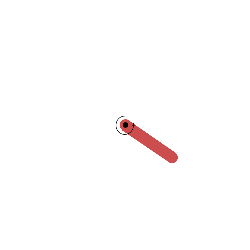

In [ ]:
#|hide
torch.manual_seed(0)

actor = Actor(3,1)

# Setup the Agent
agent = DDPGAgent(actor,max_steps=10000)

pipe = GymTransformBlock(agent=agent,n=100,seed=None,include_images=True)(['Pendulum-v1'])
pipe = VSCodeTransformBlock()(pipe)

pipe_to_device(pipe,default_device(),debug=True)

L(pipe);
pipe.show(step=2)

## Learner

In [ ]:
#|export
class BasicOptStepper(dp.iter.IterDataPipe):
    def __init__(self,
        # The parent datapipe that should produce a dict of format `{'loss':tensor(...)}`
        # all other types will be passed through.
        source_datapipe:DataPipe, 
        # The model to attach
        model:nn.Module,
        # The learning rate
        lr:float,
        # The optimizer to use
        opt:torch.optim.Optimizer=AdamW,
        # If an input is loss, catch it and prevent it from proceeding to the
        # rest of the pipeline.
        filter:bool=False,
        # Whether to `zero_grad()` before doing backward/step
        do_zero_grad:bool=True,
        # kwargs to be passed to the `opt`
        **opt_kwargs
    ):
        self.source_datapipe = source_datapipe
        self.lr = lr
        self.model = model
        self.opt = opt
        self.opt_kwargs = opt_kwargs
        self.do_zero_grad = do_zero_grad
        self.filter = filter
        self._opt = self.opt(self.model.parameters(),lr=self.lr,**self.opt_kwargs)

    def __iter__(self):
        for x in self.source_datapipe:
            if isinstance(x,dict) and 'loss' in x:
                if self.do_zero_grad: self._opt.zero_grad()
                x['loss'].backward()
                self._opt.step()
                if self.filter: continue 
            yield x

add_docs(
BasicOptStepper,
"""Optimizes `model` using `opt`. `source_datapipe` must produce a dictionary of format: `{"loss":...}`,
otherwise all non-dicts will be passed through.
"""
)

In [ ]:
#|export
class LossCollector(LogCollector):
    def __init__(self,
            source_datapipe:DataPipe, # The parent datapipe, likely the one to collect metrics from
            header:str='loss', # Name of the record. Change if using multiple instances.
            # If an input is loss, catch it and prevent it from proceeding to the
            # rest of the pipeline.
            filter:bool=False,
            # By default, LossCollector will search the pipeline for logger bases
            # and attach them here. However we can directly attach them here if
            # we need. This must be a list of lists/queues.
            main_buffers:Optional[List[List]]=None 
        ):
        self.source_datapipe = source_datapipe
        self.main_buffers = main_buffers
        self.header = header
        self.filter = filter
        
    def __iter__(self):
        for x in self.source_datapipe:
            if isinstance(x,dict) and 'loss' in x:
                for q in self.main_buffers: 
                    q.append(Record(self.header,x['loss'].cpu().detach().numpy()))
                if self.filter: continue
            yield x

    def show(self,title='Loss over N-Steps'):
        import plotly.express as px
        import plotly.io as pio
        pio.renderers.default = "plotly_mimetype+notebook_connected"

        losses = {i:[o.value for o in ls] for i,ls in enumerate(self.main_buffers)}

        fig = px.line(
            pd.DataFrame(losses),
            title=title,
            labels={
                "index": "N Steps",
                "value": "Loss"
            },
        )
        return fig.show()

add_docs(
LossCollector,
"""Itercepts dictionary results generated from `source_datapipe` that are in the 
format: `{'loss':tensor(...)}`. All other elements will be ignored and passed through.

If `filter=true`, then intercepted dictionaries will filtered out by this pipe, and will
not be propagated to the rest of the pipeline. 
""",
show="""Shows the loss over n-steps/n-batchs depending on how the loss values are loaded 
into the `main_buffers`. If there is no `LoggerBase`s, then 
`LossCollector(...,main_buffers=[[]],...)` must be passed so that 
losses can be cached for showing."""
)

In [ ]:
#|export
class SoftTargetUpdater(dp.iter.IterDataPipe):
    def __init__(
            self,
            # Expected to produces batch elements, however could be anything
            # since `SoftTargetUpdater` only tracks the number of iters.
            source_datapipe:DataPipe,
            # The model to be soft copied from
            model:nn.Module,
            # How often to soft copy the model as:
            # `n_batch%target_sync==0`
            target_sync:int=1,
            # A percent of the model to copy to the target.
            tau:float=0.001
        ):
        self.source_datapipe = source_datapipe
        self.model = model
        self.target_model = deepcopy(model)
        self.target_sync = target_sync
        self.tau = tau
        self.n_batch = 0

    def to(self,*args,**kwargs):
        self.model.to(**kwargs)
        self.target_model.to(**kwargs)

    def __iter__(self):
        for batch in self.source_datapipe:
            yield batch
            if self.n_batch%self.target_sync==0:
                for tp, fp in zip(self.target_model.parameters(), self.model.parameters()):
                    tp.data.copy_(self.tau * fp.data + (1.0 - self.tau) * tp.data)
            self.n_batch+=1

add_docs(
SoftTargetUpdater,
"""Soft-Copies `model` to a `target_model` (internal) every `target_sync` batches.""",
to="Executes `to` on `target_model` and `model`"
)


We use `SoftTargetUpdater` to update the target `Critic` and `Actor`. This is 
characterized by the notation:

$$
\theta^{Q'} \leftarrow \tau \theta^Q + (1 - \tau)\theta^{Q'}
$$
$$
\theta^{\mu'} \leftarrow \tau \theta^\mu + (1 - \tau)\theta^{\mu'}
$$

For both the `Critic`(Q) and `Actor`($\mu$) are slowly copied to their targets based on the value $\tau$

In [ ]:
#|export
def get_target_model(
        # If `model` is not none, then we assume it to be the target model
        # and simply return it, otherwise we search for a `target_model`
        model:Optional[nn.Module],
        # The pipe to start search along
        pipe:DataPipe,
        # The class of the model we are looking for
        model_cls:nn.Module,
        # A tuple of datapipes that have a field called `target_model`.
        # `get_target_model` will look for these in `pipe`
        target_updater_cls:Tuple[DataPipe]=(SoftTargetUpdater,),
        # Verbose output
        debug:bool=False
    ):
        "Basic utility for getting the 'target' version of `model_cls` in `pipe`"
        if model is not None: return model
        target_updaters = []
        for target_updater in target_updater_cls:
            target_updaters.extend(find_dps(traverse(pipe),target_updater))
        if debug: print(target_updaters)
        target_updaters = [o for o in target_updaters if isinstance(o.target_model,model_cls)]
        if debug: print(f'After filtering on {model_cls}: {target_updaters}')
        if len(target_updaters)==0: raise RuntimeError('target_updaters is empty')
        elif len(target_updaters)>1: 
            warn(f'Found multiple target updaters with {model_cls}, {target_updaters}')
        return target_updaters[0].target_model

In [ ]:
#|export
class CriticLossProcessor(dp.iter.IterDataPipe):
    debug:bool=False

    def __init__(self,
            source_datapipe:DataPipe, # The parent datapipe that should yield step types
            critic:Critic, # The critic to optimize
            # The optional target actor, where if None, will look for a 
            # target model along `source_datapipe`.
            t_actor:Optional[Actor]=None, 
            # The optional target critic, where if None, will look for a 
            # target model along `source_datapipe`.
            t_critic:Optional[Critic]=None,
            # The loss function to use
            loss:nn.Module=nn.MSELoss,
            # The discount factor of `q`. Typically does not need to be changed,
            # and determines the importants of earlier state qs verses later state qs
            discount:float=0.99,
            # If the environment has `nsteps>1`, it is recommended to change this
            # param to reflect that so the reward estimates are more accurate.
            nsteps:int=1
        ):
        self.source_datapipe = source_datapipe
        self.critic = critic
        self.t_critic = get_target_model(t_critic,source_datapipe,Critic,debug=self.debug)
        self.t_actor = get_target_model(t_actor,source_datapipe,Actor,debug=self.debug)
        self.loss = loss()
        self.discount = discount
        self.nsteps = nsteps
        self.device = None

    def to(self,*args,**kwargs):
        self.critic.to(**kwargs)
        self.t_critic.to(**kwargs)
        self.t_actor.to(**kwargs)
        self.device = kwargs.get('device',None)

    def __iter__(self) -> Union[Dict[Literal['loss'],torch.Tensor],SimpleStep]:
        for batch in self.source_datapipe:
            batch.to(self.device)
            done_mask = batch.terminated
            with torch.no_grad():
                t_actions = self.t_actor(batch.next_state)
                q = self.t_critic(batch.next_state,t_actions)

            self.critic.zero_grad()
            targets = batch.reward+q*(self.discount**self.nsteps)*(~done_mask)
            pred = self.critic(batch.state,batch.action)
            yield {'loss':self.loss(pred,targets)}
            yield batch

add_docs(
CriticLossProcessor,
r"""Produces a critic loss based on `critic`,`t_actor`,`t_critic` and batch `StepTypes`
from `source_datapipe` where the targets and predictions are fed into `loss`.

This datapipe produces either Dict[Literal['loss'],torch.Tensor] or `SimpleStep`.

From (Lilicrap et al., 2016), we expect to get N transitions from $R$ where $R$ is
`source_datapipe`.

$N$ transitions $(s_i, a_i, r_i, s_{i+1})$ from $R$ where $(s_i, a_i, r_i, s_{i+1})$
are `StepType`

The targets are similar to DQN since we are estimating the $Q$ value:

$y_i = r_i + \gamma Q' (s_{i+1}, \mu'(s_{i+1} | \theta^{\mu'})|\theta^{Q'})$

Where $y_i$ is the `targets`, $\gamma$ is the `discount**nsteps`, $Q'$ is the 
`t_critic`, $\mu'$ is the `t_actor`.

$\mu'(s_{i+1} | \theta^{\mu'})$ is the `t_actors` predicted actions of `s_{i+1}`

Update critic by minimizing the loss: $L = \frac{1}{N}\sum_i{y_i - Q(s_i,a_i|\theta^Q))^2}$

Where $Q(s_i,a_i|\theta^Q)$ is `critic(batch.state,batch.action)` and anything
with $\frac{1}{N}\sum_i{(...)}^2$ is just `nn.MSELoss`

""",
to="Executes the `to` for `critic`,`t_actor`,`t_critic` and will grab the `device` from `kwargs` if it exists."
)

In [ ]:
torch.manual_seed(0)
pipe = GymTransformBlock(agent=None,n=1000,bs=64,seed=0)(['Pendulum-v1'])
pipe = StepBatcher(pipe)

actor = Actor(3,1)
critic = Critic(3,1)

pipe = SoftTargetUpdater(pipe,critic)
pipe = CriticLossProcessor(pipe,critic,actor)

pipe_loss = LossCollector(pipe,main_buffers=[[]])
pipe = BasicOptStepper(pipe_loss,critic,1e-3)
list(pipe)
pipe_loss.show(title='Critic Loss over N-Steps')

In [ ]:
#|export
class ActorLossProcessor(dp.iter.IterDataPipe):
    def __init__(self,
            # The parent datapipe that should yield step types
            source_datapipe:DataPipe, 
            # The critic model to use.
            critic:Critic,
            # The actor to optimize.
            actor:Actor,
            # Critic grad might get very large, and so we can optionally
            # restrict it to a max/min value.
            clip_critic_grad:Optional[int]=None
        ):
        self.source_datapipe = source_datapipe
        self.critic = critic
        self.actor = actor
        self.clip_critic_grad = clip_critic_grad
        self.device = None

    def to(self,*args,**kwargs):
        self.critic.to(**kwargs)
        self.actor.to(**kwargs)
        self.device = kwargs.get('device',None)

    def __iter__(self) -> Union[Dict[Literal['loss'],torch.Tensor],SimpleStep]:
        for batch in self.source_datapipe:
            batch.to(self.device)
            self.actor.zero_grad()
            q = self.critic(batch.state,self.actor(batch.state))
            if self.clip_critic_grad is not None:
                torch.nn.utils.clip_grad_norm_(self.critic.parameters(),self.clip_critic_grad)

            loss = (-q).mean()
            yield {'loss':loss}
            yield batch

add_docs(
ActorLossProcessor,
r"""Produces a critic loss based on `critic`,`actor` and batch `StepTypes`
from `source_datapipe` where the targets and predictions are fed into `loss`.

(Lilicrap et al., 2016) notes: "The actor is updated by following the applying the chain rule
to the expected return from the start distribution J with respect to the actor parameters"

The loss is defined as the "policy gradient" below:

$$
\nabla_{\theta^{\mu}} J \approx \frac{1}{N} \sum_i{\nabla_aQ(s,a|\theta^Q)|_{s={s_i},a={\mu(s_i)}}\nabla_{\theta^{\mu}\mu(s|\theta^Q)|_{s_i}}}
$$

Where:

$\frac{1}{N} \sum_i$ is the mean.

$\nabla_{\theta^{\mu}\mu(s|\theta^Q)|_{s_i}}$ is the `actor` output.

$\nabla_aQ(s,a|\theta^Q)|_{s={s_i},a={\mu(s_i)}}$ is the `critic` output, using actions from the `actor`.

> Important: A little confusing point, $\nabla$ is the gradient/derivative of both. The point of the loss
is that we want to select actions that have `critic` output higher values. We can do this by first calling
`CriticLossProcessor` to load `critic` with gradients, then run it again but with the `actor` inputs.
We want the `actor` to have the `critic` produce more positive gradients, than negative i.e: Have actions
that maximize the critic outputs. The confusing thing is since pytorch has autograd, the actual
code is not going to match the math above, for good and bad. 

TODO: It would be helpful if this documentation can be better explained.

> Note: We actually multiply `J` by -1 since the optimizer is trying to make the value 
as "small" as possible, but the actual value we want to be as big as possible. 
So if we have a `J` of 100 (high reward), it becomes -100, letting the optimizer know that
it is moving is the correct direction (the more negative, the better). 
""",
to="Executes the `to` for `critic`,`actor` and will grab the `device` from `kwargs` if it exists."
)

In [ ]:
actor = Actor(3,1)
critic = Critic(3,1)

agent = DDPGAgent(actor,max_steps=10000)

pipe = GymTransformBlock(agent=agent,n=1000,bs=10)(['Pendulum-v1'])
pipe = StepBatcher(pipe)

pipe = ActorLossProcessor(pipe,critic,actor)

pipe_loss = LossCollector(pipe,main_buffers=[[]])
pipe = BasicOptStepper(pipe_loss,actor,1e-3)
list(pipe)
pipe_loss.show()

In [ ]:
#|export
def DDPGLearner(
    # The actor model to use
    actor:Actor,
    # The critic model to use
    critic:Critic,
    # A list of dls, where index=0 is the training dl.
    dls:List[DataPipeOrDataLoader],
    # Optional logger bases to log training/validation data to.
    logger_bases:Optional[List[LoggerBase]]=None,
    # The learning rate for the actor. Expected to learn slower than the critic
    actor_lr:float=1e-3,
    # The optimizer for the actor
    actor_opt:torch.optim.Optimizer=Adam,
    # The learning rate for the critic. Expected to learn faster than the actor
    critic_lr:float=1e-2,
    # The optimizer for the critic
    # Note that weight decay doesnt seem to be great for 
    # Pendulum, so we use regular Adam, which has the decay rate
    # set to 0. (Lilicrap et al., 2016) would instead use AdamW
    critic_opt:torch.optim.Optimizer=Adam,
    # Reference: SoftTargetUpdater docs
    critic_target_copy_freq:int=1,
    # Reference: SoftTargetUpdater docs
    actor_target_copy_freq:int=1,
    # Reference: SoftTargetUpdater docs
    tau:float=0.001,
    # Reference: ExperienceReplay docs 
    bs:int=128,
    # Reference: ExperienceReplay docs
    max_sz:int=10000,
    # Reference: GymStepper docs
    nsteps:int=1,
    # The device for the entire pipeline to use. Will move the agent, dls, 
    # and learner to that device.
    device:torch.device=None,
    # Number of batches per epoch
    batches:int=None,
    # Any augmentations to the learner
    dp_augmentation_fns:Optional[List[DataPipeAugmentationFn]]=None,
    # Debug mode will output device moves
    debug:bool=False
) -> LearnerHead:
    learner = LearnerBase(actor,dls,batches=batches)
    learner = LoggerBasePassThrough(learner,logger_bases)
    learner = BatchCollector(learner,batch_on_pipe=LearnerBase)
    learner = EpocherCollector(learner)
    for logger_base in L(logger_bases): learner = logger_base.connect_source_datapipe(learner)
    if logger_bases: 
        learner = RollingTerminatedRewardCollector(learner)
        learner = EpisodeCollector(learner)
    learner = ExperienceReplay(learner,bs=bs,max_sz=max_sz)
    learner = StepBatcher(learner)
    learner = SoftTargetUpdater(learner,critic,target_sync=critic_target_copy_freq,tau=tau)
    learner = SoftTargetUpdater(learner,actor,target_sync=actor_target_copy_freq,tau=tau)
    learner = CriticLossProcessor(learner,critic,actor,nsteps=nsteps)
    learner = LossCollector(learner,header='critic-loss')
    learner = BasicOptStepper(learner,critic,critic_lr,opt=critic_opt,filter=True,do_zero_grad=False)
    learner = ActorLossProcessor(learner,critic,actor,clip_critic_grad=5)
    learner = LossCollector(learner,header='actor-loss')
    learner = BasicOptStepper(learner,actor,actor_lr,opt=actor_opt,filter=True,do_zero_grad=False)
    learner = LearnerHead(learner)
    
    learner = apply_dp_augmentation_fns(learner,dp_augmentation_fns)
    pipe_to_device(learner,device,debug=debug)
    for dl in dls: pipe_to_device(dl.datapipe,device,debug=debug)
    
    return learner

DDPGLearner.__doc__="""DDPG is a continuous action, actor-critic model, first created in
(Lilicrap et al., 2016). The critic estimates a Q value estimate, and the actor
attempts to maximize that Q value."""

In [ ]:
#|eval:false
# Setup Loggers
logger_base = ProgressBarLogger(epoch_on_pipe=EpocherCollector,
                 batch_on_pipe=BatchCollector)

# Setup up the core NN
torch.manual_seed(0)
actor = Actor(3,1)
critic = Critic(3,1)

# Setup the Agent
agent = DDPGAgent(actor,[logger_base],max_steps=5000,min_epsilon=0.1)

# Setup the DataBlock
block = DataBlock(
    GymTransformBlock(agent=agent,nsteps=2,nskips=2,firstlast=True), 
    (GymTransformBlock(agent=agent,n=400,nsteps=2,nskips=2,firstlast=True,include_images=True),VSCodeTransformBlock())
)
dls = L(block.dataloaders(['Pendulum-v1']*1))
# Setup the Learner
learner = DDPGLearner(actor,critic,dls,logger_bases=[logger_base],
                      bs=128,max_sz=20_000,nsteps=2,
                      batches=1000)
# learner.fit(1)
learner.fit(15)

actor-loss,critic-loss,episode,rolling_reward,epoch,batch
23.484377,2.7217586,10,-1606.006924,1,1001
31.69706,12.016734,20,-1542.288166,2,1001
40.06336,25.084415,30,-1472.712552,3,1001
50.46943,7.714135,40,-1450.873017,4,1001
59.180523,17.604204,50,-1406.556492,5,1001
67.14108,46.2947,60,-1338.766411,6,1001
68.84964,16.201414,70,-1135.972938,7,1001
69.09436,143.93195,80,-993.549349,8,1001
69.35192,25.970486,90,-817.256042,9,1001
73.09758,171.4342,100,-673.698936,10,1001


Creating gif from 400 frames


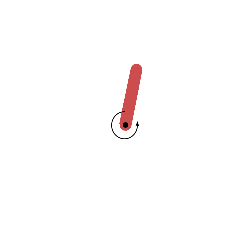

In [ ]:
#|hide
#|eval:false
learner.validate()

In [ ]:
#|hide
#|eval: false
from fastcore.imports import in_colab

# Since colab still requires tornado<6, we don't want to import nbdev if we don't have to
if not in_colab():
    from nbdev import nbdev_export
    nbdev_export()